In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os

from langchain.agents import Tool

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver

In [8]:
load_dotenv(override=True)

True

<h4>Asynchronous LangGraph</h4>
To run a tool:
Sync: <code>tool.run(inputs)</code><br>
Async: <code>await tool.arun(inputs)</code>

To invoke the graph:<br>
Sync: <code>graph.invoke(state)</code><br>
Async: <code>await graph.ainvoke(state)</code>

In [9]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [10]:
pushover_token=os.getenv("PUSHOVER_TOKEN")
pushover_user=os.getenv("PUSHOVER_USER")
pushover_url=os.getenv("PUSHOVER_URL")

def push(text: str):
    """ Send a push notification to the user """
    requests.post(pushover_url,data={"token":pushover_token,"user":pushover_user,"message":text})

tool_push=Tool(
    name="send_push_notification",
    func=push,
    description="useful for when we want to send a push notification"
)

In [31]:
# Introducing nest_asyncio
# Python async code only allows for one "event loop" processing aynchronous events.
# The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

# import nest_asyncio
# nest_asyncio.apply()

import os
os.environ["UVLOOP_NO_EXTENSIONS"] = "1"

import asyncio, nest_asyncio
try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

nest_asyncio.apply()



<h2>Let's try to integrate ZenRows for webscrapping</h2>

In [42]:
# from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
# from langchain_community.tools.playwright.utils import create_async_playwright_browser

# # If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

# async_browser =  create_async_playwright_browser(headless=False)  # headful mode
# toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
# tools = toolkit.get_tools()


from langgraph.prebuilt import ToolNode, tools_condition
from bs4 import BeautifulSoup

def navigate_url(inputs: dict) -> str:
    """Fetch a webpage (JS rendered) via ZenRows API."""
    url = inputs.get("url")
    resp = requests.get(
        "https://api.zenrows.com/v1/",
        params={"url": url, "apikey": os.getenv('ZENROWS_API_KEY')}
    )
    return resp.text

def extract_text(inputs: dict) -> str:
    """Extract visible text from previously fetched HTML."""
    html = inputs.get("html")
    if not html:
        return "No HTML provided"
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text(" ", strip=True)

# Wrap as LangChain Tools
navigate_tool = Tool(
    name="navigate_url",
    func=navigate_url,
    description="Navigate to a URL and fetch its rendered HTML using ZenRows."
)

extract_text_tool = Tool(
    name="extract_text",
    func=extract_text,
    description="Extract plain text content from HTML."
)

In [43]:
tools = [tool_push, navigate_tool, extract_text_tool]

In [44]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

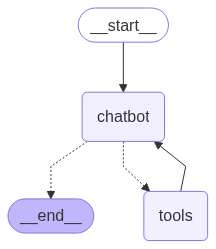

In [45]:
# Step 1 and 2

# Step 1: Define the State object
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)

# Step 3
llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001",google_api_key=os.getenv('GEMINI_ACCESS_KEY'))
llm_with_toolss=llm.bind_tools(tools)


async def chatbot(state: State):
    # return {"messages":[llm_with_toolss.invoke(state["messages"])]}
    return {"messages":[await llm_with_toolss.ainvoke(state["messages"])]}

graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot", END)

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
%pip uninstall uvloop

Found existing installation: uvloop 0.21.0
Uninstalling uvloop-0.21.0:
  Would remove:
    /Users/himanshu.r.singh/Desktop/AgenticAI/agenticAI/lib/python3.13/site-packages/uvloop-0.21.0.dist-info/*
    /Users/himanshu.r.singh/Desktop/AgenticAI/agenticAI/lib/python3.13/site-packages/uvloop/*
Proceed (Y/n)? ^C
Note: you may need to restart the kernel to use updated packages.


In [47]:
config={"configurable":{"thread_id":"1"}}

# @traceable(name="chat")
def chat(user_input:str,history):
    result= graph.invoke({"messages":[{"role":"user","content":user_input}]},config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat,type="messages").launch()

Exception in thread Thread-148 (run):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/Users/himanshu.r.singh/Desktop/AgenticAI/agenticAI/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/himanshu.r.singh/Desktop/AgenticAI/agenticAI/lib/python3.13/site-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/himanshu.r.singh/Desktop/AgenticAI/agenticAI/lib/python3.13/site-packag

KeyboardInterrupt: 